# Ensemble Testing
This Notebook is used to test the performance of a GNN ensemble.
The training of ```n_reps``` models is done in ```ensemble_train.py``` and can be configured using ```ensemble_config.yaml```.

In [88]:
ensemble_config = "experiments/small/best_GlobalInfo/config.yaml"

In [89]:
import sys
import subprocess
from multiprocessing import Process

In [90]:
def split_list(input_list, n):
    return [input_list[i:i + n] for i in range(0, len(input_list), n)]

def run_script(params):
    """
    Train a single model by launching a single subprocess facilitating the training
    :param params: tuple containing the id of the run, the device number and the name of the config file for the run
    """
    if "small" in params[2]:
        small = True
    else:
        small = False

    id_val, device_val, config_val = params
    cmd = [sys.executable, "ensemble_train.py", "--id", str(id_val), "--device", str(device_val), "--config", config_val, "--small" if small else "--no-small"]
    subprocess.run(cmd)

def train_ensemble(config_path, n):
    """
    Trains an ensemble of models
    :param config_path: path to the config file of the models
    :param n: number of models to train in parallel
    """
    params = [(i, i%2, config_path) for i in range(10)]
    params_list_list = split_list(params, n)

    for params_list in params_list_list:
        print(f"Start training of models")
        processes = []
        for params in params_list:
            print(params[0])
            process = Process(target=run_script, args=(params,))
            processes.append(process)
            process.start()

        for process in processes:
            process.join()

In [91]:
%%time
train_ensemble(ensemble_config, 10)

Start training of models
0
1
2
3
4
5
6
7
8
9
Model 0 start
Stopped 0
Model 4 start
Stopped 4
Model 1 start
Stopped 1
Model 3 start
Stopped 3
Model 9 start
Stopped 9
Model 6 start
Stopped 6
Model 8 start
Stopped 8
Model 2 start
Stopped 2
Model 7 start
Stopped 7
Model 5 start
Stopped 5
CPU times: user 143 ms, sys: 706 ms, total: 849 ms
Wall time: 3min 34s


# Evaluation

In [92]:
from ensemble_train import crps, create_model
import numpy as np
import os
import sys
import torch
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import yaml

sys.path.append('../utils')
import helpers

with open(ensemble_config, 'r') as config_file:
    config = yaml.safe_load(config_file)

save_path = os.path.dirname(ensemble_config)

In [93]:
# Get Data from feather
print("Loading Data ...")
data = helpers.load_data(indexed=False)

if not os.path.exists("dist_matrix.npy"):
    print("Creating distance matrix ...")
    stations = helpers.load_stations(data)  # This needs to be done here because we need all stations
    dist_matrix = helpers.compute_dist_matrix(stations)
    np.save('dist_matrix.npy', dist_matrix)

# Clean Data
print("Cleaning Data ...")
data = helpers.clean_data(data, max_missing=121, max_alt=1000.0)

# Normalize Data
print("Normalizing Data ...")
normalized_data = helpers.normalize_data(data, last_obs=-366, method="max") #last_obs is -365 since the last year is used for testing

# Get List of stations with all stations -> will break further code if cut already
print("Extracting Stations ...")
stations = helpers.load_stations(data)


dist_matrix = np.load('dist_matrix.npy')
corr_matrix = np.load('corr_matrix.npy')
position_matrix = np.array(stations[['station', 'lon', 'lat']])


torch_data_test = []
for date in tqdm(data['date'].unique()[-366:], desc="Creating PyG Data"):
    torch_data_test.append(helpers.create_data(df=normalized_data,
                                               date=date,
                                               dist_matrix=dist_matrix if not config['data']['use_corr'] else corr_matrix,
                                               position_matrix=position_matrix,
                                               method=config['data']['method'],
                                               max_dist=config['data']['max_dist'],
                                               k=config['data']['nearest_k'],
                                               nearest_k_mode=config['data']['nearest_k_mode']))

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Move all the data directly to the GPU (should fit into memory)
# torch_data_train only contains training datat 2007-2015
torch_data_test = [tensor.to(device) for tensor in torch_data_test]

# Definition of train_loader and valid_loader
test_loader = DataLoader(torch_data_test, batch_size=8, shuffle=False)

Loading Data ...
Cleaning Data ...
Normalizing Data ...
Extracting Stations ...


Creating PyG Data: 100%|██████████| 366/366 [00:02<00:00, 129.61it/s]


In [94]:
def get_models_from_checkpoints():
    emb_num_features = torch_data_test[0].num_features + config['model']['embed_dim'] - 1

    model_list = []
    for snapshot in os.listdir(f"{os.path.dirname(ensemble_config)}/checkpoints"):
        path_to_snapshot = f"{os.path.dirname(ensemble_config)}/checkpoints/{snapshot}"
        model = create_model(config, emb_num_features)
        try:
            checkpoint = torch.load(path_to_snapshot)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            model_list.append(model)
        except:
            print(f"could not load {path_to_snapshot}, model architectures do not match")
    return model_list

def evaluate_ensemble(model_list:list):
    mu_list_model = []
    sigma_list_model = []

    for model in model_list:
        mu_list_batch = []
        sigma_list_batch = []
        y_list = []

        for batch in test_loader:
            batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            mu, sigma = torch.split(out, 1, dim=-1)
            y = batch.y
            y = y.cpu().numpy()
            y_list.append(y)

            mu = mu.detach().cpu().numpy().flatten()
            mu_list_batch.append(mu)
            sigma = sigma.detach().cpu().numpy().flatten()
            sigma_list_batch.append(sigma)


        mu = np.concatenate(mu_list_batch)
        mu_list_model.append(mu)
        sigma = np.concatenate(sigma_list_batch)
        sigma_list_model.append(sigma)
        y = np.concatenate(y_list)
    mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
    sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)

    mu = torch.tensor(mu).to(device)
    sigma = torch.tensor(sigma).to(device)
    preds = torch.cat([mu, sigma], dim=1)
    y = torch.tensor(y).to(device)
    err = crps(mu_sigma=preds, y=y)

    y = y.detach().cpu().numpy()
    mu = mu.detach().cpu().numpy()
    sigma = sigma.detach().cpu().numpy()
    return err, mu, sigma, y

In [95]:
ensemble = get_models_from_checkpoints()
err, mu, sigma, y = evaluate_ensemble(ensemble)
print(err)

tensor(1.1440, device='cuda:1')


# Plot
## Observed vs. Actual value

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

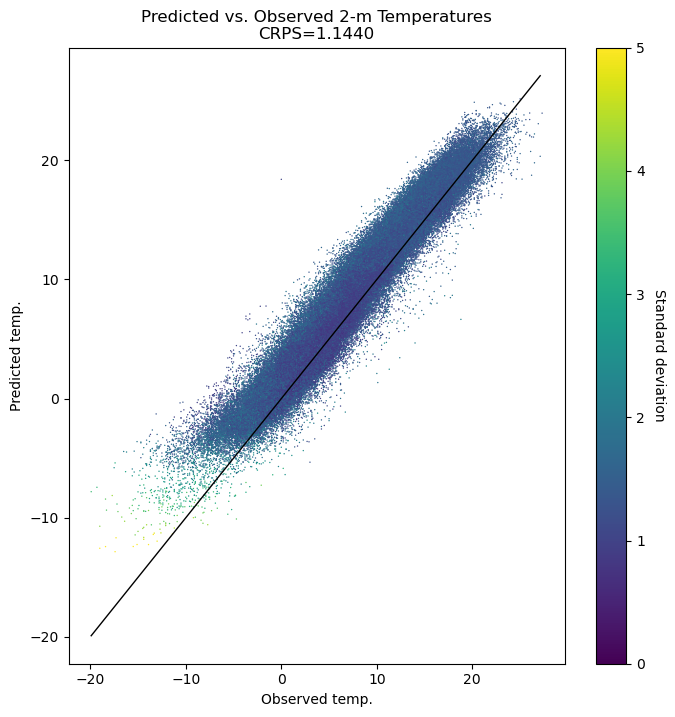

In [97]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")  # line
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis", vmin=0, vmax=5)

cbar = plt.colorbar()
cbar.set_label('Standard deviation', rotation=270, labelpad=15)
plt.xlabel('Observed temp.')
plt.ylabel('Predicted temp.')
plt.title(f"Predicted vs. Observed 2-m Temperatures\nCRPS={err:.4f}")
plt.savefig(f"{save_path}/predsObs.eps", format='eps', dpi=300, bbox_inches='tight')

## PIT Histogram

In [98]:
from scipy.stats import norm

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


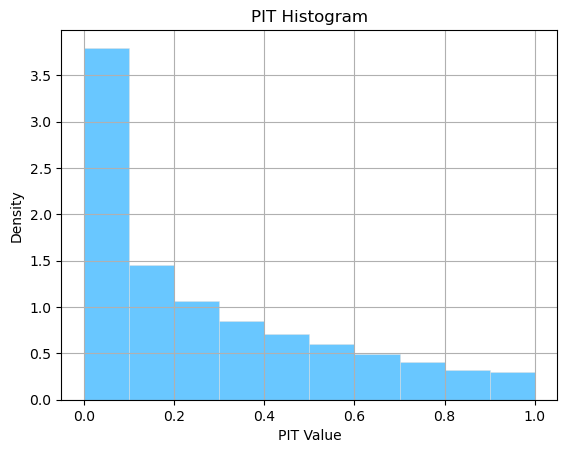

In [99]:
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
plt.hist(probs, bins=10, density=True, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.title('PIT Histogram')
plt.grid(True)
plt.savefig(f"{save_path}/PIT.eps", format='eps', dpi=300, bbox_inches='tight')

## Kolmogorow-Smirnow-Test
The Kolmogorov-Smirnov test is a non-parametric statistical test used to assess whether a sample comes from a specific distribution. It is based on the comparison of the empirical distribution function of the sample with the cumulative distribution function of the hypothesized distribution.
$H_0: F_X=F_0\\
H_1: F_X \neq F_0$

In [53]:
from scipy.stats import kstest, uniform

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(probs, uniform.cdf)

print(p_value)

2.976617524190563e-47
